Quantum object: dims=[[2, 2], [1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[-0.0554972 -0.51184116j]
 [ 0.03470987+0.49742693j]
 [ 0.02485753+0.48712121j]
 [ 0.06186484+0.4945383j ]]


100%|██████████| 456/456 [01:40<00:00,  4.55it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 800) to (1008, 800) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved to tp.mp4


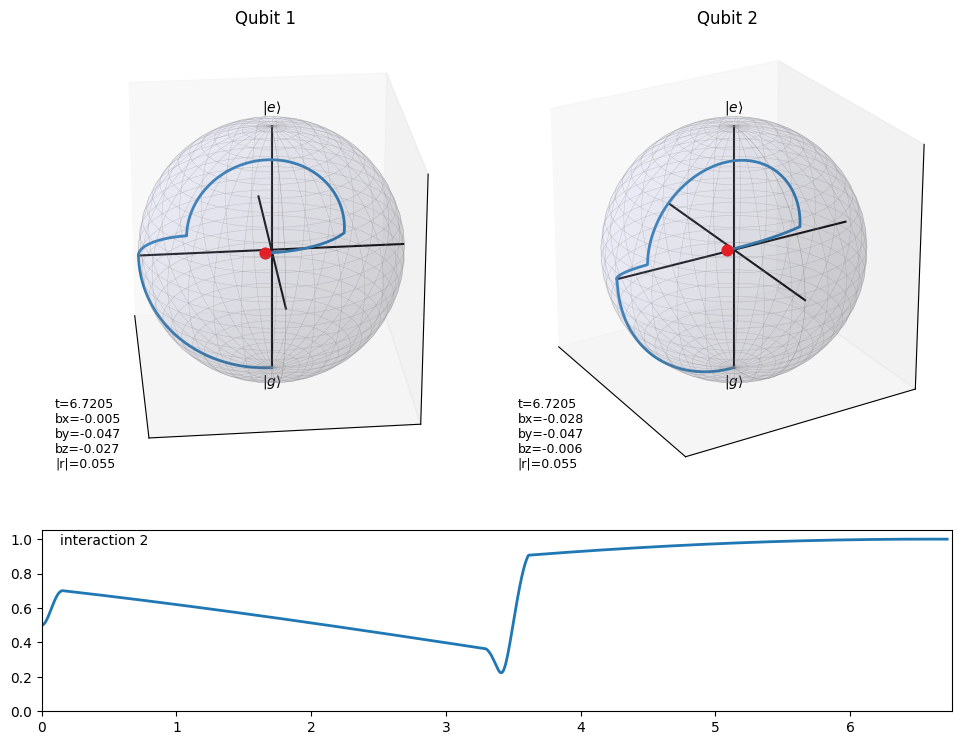

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import imageio
from tqdm import tqdm

# ============================================================
# PARAMETERS
# ============================================================

Delta1 = 0.1
Delta2 = 0.2
V0 = 0.5

Omega = 10.0
Omega_g1 = np.sqrt(Omega**2 + Delta1**2)
Omega_g2 = np.sqrt(Omega**2 + Delta2**2)
Omega_g = max(Omega_g1,Omega_g2)

t_pi2 = np.pi / (2 * Omega_g)
t_pi  = np.pi / Omega_g
t_wait = np.pi / (2 * V0)

T1 = t_pi2
T2 = T1 + t_wait
T3 = T2 + t_pi
T4 = T3 + t_wait

tlist = np.linspace(0, T4, 1400)

# ============================================================
# VARIABLE SPEED PLAYBACK — chronological repetition
# ============================================================
# Choose how slow pulses appear (repeat factor) and how many repeats for free evolution
slow_factor = 3   # repeated frames for pulse segments (slow motion)
fast_stride= 8   # repeated frames for free-evolution segments (small speedup; set 1 to not repeat)
# ============================================================
# OPERATORS
# ============================================================

sx, sy, sz = sigmax(), sigmay(), sigmaz()
I = qeye(2)

sx1, sx2 = tensor(sx, I), tensor(I, sx)
sz1, sz2 = tensor(sz, I), tensor(I, sz)

e = basis(2,1)
Pe = e*e.dag()
Pe1e2 = tensor(Pe, Pe)

H0 = (Delta1/2)*sz1 + (Delta2/2)*sz2 + V0*Pe1e2

# ============================================================
# PULSE SEQUENCE
# ============================================================

def global_pulse(t, args):
    if 0 <= t <= T1:
        return Omega
    elif T2 <= t <= T3:
        return Omega
    else:
        return 0.0

H = [H0, [(sx1 + sx2)/2, global_pulse]]

psi0 = tensor(basis(2,0), basis(2,0))

# ============================================================
# SOLVE
# ============================================================

result = sesolve(H, psi0, tlist)
print(result.states[-1])

# ============================================================
# BLOCH VECTORS
# ============================================================

b1x,b1y,b1z = [],[],[]
b2x,b2y,b2z = [],[],[]

for psi in result.states:
    r1 = psi.ptrace(0)
    r2 = psi.ptrace(1)

    b1x.append(expect(sx,r1))
    b1y.append(expect(sy,r1))
    b1z.append(-expect(sz,r1))

    b2x.append(expect(sx,r2))
    b2y.append(expect(sy,r2))
    b2z.append(-expect(sz,r2))

b1x,b1y,b1z = map(np.array,[b1x,b1y,b1z])
b2x,b2y,b2z = map(np.array,[b2x,b2y,b2z])


# ============================================================
# TARGET & FIDELITY (keep optional display)
# ============================================================

psi_target = -1j*(tensor(basis(2,0),basis(2,0)) -
              tensor(basis(2,0),basis(2,1)) -
              tensor(basis(2,1),basis(2,0)) -
              tensor(basis(2,1),basis(2,1))).unit()

fidelity_t = np.array([fidelity(psi, psi_target) for psi in result.states])

frame_indices = []

for i in range(len(tlist)):
    if (tlist[i] <= T1) or (T2 <= tlist[i] <= T3):
        # Pulse → slow
        frame_indices.extend([i] * slow_factor)
    else:
        # Interaction → fast
        if i % fast_stride == 0:
            frame_indices.append(i)

frame_indices = np.array(frame_indices)

# ============================================================
# ANIMATION (with optional fidelity subplot)
# ============================================================

def animate(filename="cz_with_fidelity_fixed.mp4", fps=30, show_fidelity=True):
    # Layout: make Bloch spheres larger relative to plot if fidelity shown
    if show_fidelity:
        fig = plt.figure(figsize=(10,8))
        gs = fig.add_gridspec(2, 2, height_ratios=[3, 1])  # top 2/3 for spheres, bottom 1/3 for fidelity
        ax1 = fig.add_subplot(gs[0, 0], projection="3d")  # left Bloch sphere
        ax2 = fig.add_subplot(gs[0, 1], projection="3d")  # right Bloch sphere
        axf = fig.add_subplot(gs[1, :])                    # fidelity below, spans both columns
        axf.set_title("Fidelity", fontsize=12)
        axf.set_xlabel("Time", fontsize=10)
        axf.set_ylabel("F", fontsize=10)
        axf.set_xlim(0, tlist[-1])
        axf.set_ylim(0, 1.05)

        # Optional: make layout tight to ensure labels are visible
        fig.tight_layout()
    else:
        fig = plt.figure(figsize=(10,6))
        ax1 = fig.add_subplot(121, projection="3d")
        ax2 = fig.add_subplot(122, projection="3d")
        axf = None


    # prepare sphere geometry
    u = np.linspace(0,2*np.pi,60)
    v = np.linspace(0,np.pi,30)
    xs = np.outer(np.cos(u), np.sin(v))
    ys = np.outer(np.sin(u), np.sin(v))
    zs = np.outer(np.ones_like(u), np.cos(v))

    frames = []
    for k in tqdm(range(len(frame_indices))):

        i = frame_indices[k]

        # clear axes
        ax1.clear(); ax2.clear()
        if axf is not None:
            axf.clear()

        # draw Bloch 1
        ax = ax1
        ax.plot_surface(xs, ys, zs, color=(0.8,0.8,1), alpha=0.12, linewidth=0)
        ax.plot_wireframe(xs, ys, zs, color="gray", linewidth=0.3, alpha=0.4)
        ax.plot([-1,1],[0,0],[0,0],'k'); ax.plot([0,0],[-1,1],[0,0],'k'); ax.plot([0,0],[0,0],[-1,1],'k')
        ax.plot(b1x[:i+1], b1y[:i+1], b1z[:i+1], lw=2)
        ax.scatter(b1x[i], b1y[i], b1z[i], color='r', s=60)
        
        az = np.degrees(np.arctan2(b1y[i], b1x[i] + 1e-16))
        ax.view_init(elev=25, azim=az + 90.0)


        ax.set_xlim([-1,1]); ax.set_ylim([-1,1]); ax.set_zlim([-1,1])
        ax.set_box_aspect([1,1,1])
        ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
        ax.text(0,0,1.12,r"$|e\rangle$",ha="center"); ax.text(0,0,-1.15,r"$|g\rangle$",ha="center")
        ax.set_title("Qubit 1")
        rmag1 = np.sqrt(b1x[i]**2 + b1y[i]**2 + b1z[i]**2)
        info1 = (f"t={tlist[i]:.4f}\n"
                 f"bx={b1x[i]:+.3f}\n"
                 f"by={b1y[i]:+.3f}\n"
                 f"bz={b1z[i]:+.3f}\n"
                 f"|r|={rmag1:.3f}")
        ax.text2D(0.03, 0.02, info1, transform=ax.transAxes, fontsize=9, va="bottom")

        # draw Bloch 2
        ax = ax2
        ax.plot_surface(xs, ys, zs, color=(0.8,0.8,1), alpha=0.12, linewidth=0)
        ax.plot_wireframe(xs, ys, zs, color="gray", linewidth=0.3, alpha=0.4)
        ax.plot([-1,1],[0,0],[0,0],'k'); ax.plot([0,0],[-1,1],[0,0],'k'); ax.plot([0,0],[0,0],[-1,1],'k')
        ax.plot(b2x[:i+1], b2y[:i+1], b2z[:i+1], lw=2)
        ax.scatter(b2x[i], b2y[i], b2z[i], color='r', s=60)

        az = np.degrees(np.arctan2(b2y[i], b2x[i] + 1e-16))
        ax.view_init(elev=25, azim=az + 90.0)
        
        ax.set_xlim([-1,1]); ax.set_ylim([-1,1]); ax.set_zlim([-1,1])
        ax.set_box_aspect([1,1,1])
        ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
        ax.text(0,0,1.12,r"$|e\rangle$",ha="center"); ax.text(0,0,-1.15,r"$|g\rangle$",ha="center")
        ax.set_title("Qubit 2")
        rmag2 = np.sqrt(b2x[i]**2 + b2y[i]**2 + b2z[i]**2)
        info2 = (f"t={tlist[i]:.4f}\n"
                 f"bx={b2x[i]:+.3f}\n"
                 f"by={b2y[i]:+.3f}\n"
                 f"bz={b2z[i]:+.3f}\n"
                 f"|r|={rmag2:.3f}")
        ax.text2D(0.03, 0.02, info2, transform=ax.transAxes, fontsize=9, va="bottom")

        # fidelity subplot (optional)
        if axf is not None:
            axf.plot(tlist[:i+1], fidelity_t[:i+1], lw=2)
            axf.set_xlim(0, tlist[-1]); axf.set_ylim(0,1.05)
            # annotate which segment we're in by checking pulse(t)
            pval = global_pulse(tlist[i], None)
            if pval > 0:
                # determine which pulse
                if 0.0 <= tlist[i] <= T1:
                    phase = "π/2 pulse"
                else:
                    phase = "π pulse"
            else:
                # interaction regions
                if (T1 < tlist[i] < T2):
                    phase = "interaction 1"
                elif (T3 < tlist[i] < T4):
                    phase = "interaction 2"
                else:
                    phase = "free"
            axf.text(0.02, 0.92, phase, transform=axf.transAxes, fontsize=10)

        # render and append
        fig.canvas.draw()
        img = np.asarray(fig.canvas.buffer_rgba())[:,:,:3].copy()
        frames.append(img)

    # save
    imageio.mimsave(filename, frames, fps=fps)
    print("Saved to", filename)

# Example usage:
# animate(filename="fixed_order_cz.mp4", fps=30, show_fidelity=True)
animate(filename="tp.mp4", fps=25, show_fidelity=True)


0it [00:00, ?it/s]

500it [21:29,  2.58s/it]


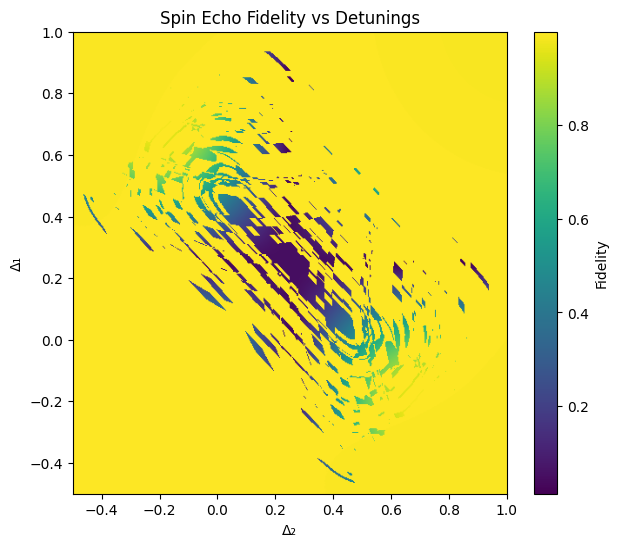

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm

# ============================================================
# GRID OF DETUNINGS
# ============================================================

d1_vals = np.linspace(-0.5, 1.0, 500)
d2_vals = np.linspace(-0.5, 1.0, 500)

fid = np.zeros((len(d1_vals), len(d2_vals)))

# constants
V0 = 0.5
Omega = 10.0

# operators
sx, sy, sz = sigmax(), sigmay(), sigmaz()
I = qeye(2)
sx1, sx2 = tensor(sx, I), tensor(I, sx)
sz1, sz2 = tensor(sz, I), tensor(I, sz)

e = basis(2,1)
Pe = e*e.dag()
Pe1e2 = tensor(Pe, Pe)

# initial and target states
psi0 = tensor(basis(2,0), basis(2,0))
psi_target = -1j*(tensor(basis(2,0),basis(2,0)) -
                  tensor(basis(2,0),basis(2,1)) -
                  tensor(basis(2,1),basis(2,0)) -
                  tensor(basis(2,1),basis(2,1))).unit()

# ============================================================
# LOOP OVER DETUNINGS
# ============================================================

for i, Delta1 in tqdm(enumerate(d1_vals)):
    for j, Delta2 in enumerate(d2_vals):

        # generalized Rabi frequencies
        Omega_g1 = np.sqrt(Omega**2 + Delta1**2)
        Omega_g2 = np.sqrt(Omega**2 + Delta2**2)
        Omega_g = max(Omega_g1, Omega_g2)

        # pulse durations
        t_pi2 = np.pi / (2 * Omega_g)
        t_pi  = np.pi / Omega_g
        t_wait = np.pi / (2 * V0)

        T1 = t_pi2
        T2 = T1 + t_wait
        T3 = T2 + t_pi
        T4 = T3 + t_wait

        tlist = np.linspace(0, T4, 400)

        # static Hamiltonian
        H0 = (Delta1/2)*sz1 + (Delta2/2)*sz2 + V0*Pe1e2

        # pulse function
        def global_pulse(t, args):
            if 0 <= t <= T1:
                return Omega
            elif T2 <= t <= T3:
                return Omega
            else:
                return 0.0

        H = [H0, [(sx1 + sx2)/2, global_pulse]]

        # evolve
        result = sesolve(H, psi0, tlist)
        psi_final = result.states[-1]

        fid[i,j] = fidelity(psi_final, psi_target)

# ============================================================
# PLOT
# ============================================================

plt.figure(figsize=(7,6))
plt.imshow(fid,
           extent=[d2_vals[0], d2_vals[-1], d1_vals[0], d1_vals[-1]],
           origin='lower',
           aspect='auto')
plt.colorbar(label="Fidelity")
plt.xlabel("Δ₂")
plt.ylabel("Δ₁")
plt.title("Spin Echo Fidelity vs Detunings")
plt.show()
